<a href="https://colab.research.google.com/github/henriquedalga/AI-English-Tutor-with-Gemini/blob/main/AI_English_Tutor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instrutor virtual de inglês para praticar conversação**

In [57]:
from IPython.display import Audio, display
from gtts import gTTS
texto = "Olá! I'm Gemini, your friendly AI English tutor. Do you want to improve your English speaking and writing skills? I'm here to help! Through engaging conversation, I can answer your questions, correct your grammar, expand your vocabulary, and provide personalized feedback on your English. Think of me as your personal English coach available 24/7. We can chat about anything you like, from everyday topics to complex discussions - all while improving your English skills naturally. So, what are you waiting for? Let's start chatting and take your English fluency to the next level!"
language = 'en'
myobj = gTTS(text=texto, lang=language, slow=False)
myobj.save("Welcome.mp3")
display(Audio("/content/Welcome.mp3", autoplay=True))

Muitos estudantes possuem conhecimento em inglês, porém a falta de prática impede sua evolução. Nem sempre temos alguém para praticar o inglês. Assim, essa é uma aplicação que proporciona um assistente virtual para poder praticar conversação e até tirar dúvidas. O Gemini será seu assistente e irá conversar em inglês com você!

Aperte o botão para falar e espere a mágica.

configurando a API do Google Gemini

In [21]:
!pip install -q -U google-generativeai

In [22]:
from pathlib import Path
import hashlib
import google.generativeai as genai
from google.colab import userdata

my_api = userdata.get('secretName')
genai.configure(api_key=my_api)

In [53]:
# Set up the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 0,
  "max_output_tokens": 8192,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
]

system_instruction = "você é um professor de inglês. Você irá responder perguntas e corrigir erros enquanto conversa."

model = genai.GenerativeModel(model_name="gemini-1.5-pro-latest",
                              generation_config=generation_config,
                              safety_settings=safety_settings)

**Código para gravar áudio:**

In [48]:
#imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment


**Algoritmo para gravar audio até identificar uma pausa (silêncio)**

In [49]:

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise((resolve, reject) => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.target.result)
  reader.onerror = e => reject(new Error("Failed to read blob"))
  reader.readAsDataURL(blob)
})
var recordUntilSilence = time => new Promise(async (resolve, reject) => {
  let stream, recorder, chunks, blob, text, audioContext, analyser, dataArr, silenceStart, threshold = 50, silenceDelay = 2000
  try {
    stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  } catch (err) {
    return reject(new Error("Failed to get media stream"))
  }
  audioContext = new AudioContext()
  const source = audioContext.createMediaStreamSource(stream)
  analyser = audioContext.createAnalyser()
  analyser.fftSize = 512
  dataArr = new Uint8Array(analyser.frequencyBinCount)
  source.connect(analyser)
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.onstop = async () => {
    blob = new Blob(chunks)
    try {
      text = await b2text(blob)
      resolve(text)
    } catch (err) {
      reject(new Error("Failed to convert blob to text"))
    }
  }
  recorder.onerror = e => reject(new Error("Recorder error"))
  recorder.start()
  const checkSilence = () => {
    analyser.getByteFrequencyData(dataArr)
    const avg = dataArr.reduce((p, c) => p + c, 0) / dataArr.length

    if (avg < threshold) {
      if (silenceStart === null) silenceStart = new Date().getTime()
      else if (new Date().getTime() - silenceStart > silenceDelay) {
        recorder.stop()
        audioContext.close()
        return
      }
    } else {
      silenceStart = null
    }
    requestAnimationFrame(checkSilence)
  }
  silenceStart = null
  checkSilence()
})
console.log("JavaScript code executed successfully.")
"""


**Detalhes de implementação para salvar no formato wave**

In [25]:
!pip install ffmpeg-python
import ffmpeg

def fix_riff_header(binary):
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]
  return riff

**Funcão que executa a gravação e salva o arquivo**

In [47]:
def record_until_silence():
  try:
    display(Javascript(RECORD))
    s = output.eval_js('recordUntilSilence()')
    b = b64decode(s.split(',')[1])
    c = fix_riff_header(b)
    with open('audio.wav','wb') as f:
      f.write(c)
  except Exception as e:
    print(f"An error occurred: {e}")
    return None

In [46]:
# Funcão para carregar o arquivo de áudio na IA
def ouvir():
  record_until_silence()
  audio_file = genai.upload_file(path="/content/audio.wav", display_name="audio.wav")
  return audio_file

API para utilizar o serviço do google tradutor de transformar texto em voz:

In [36]:
!pip install -q gTTS

In [51]:
from IPython.display import Audio, display
from gtts import gTTS
def playSound(text_to_speak):

  # The text that you want to convert to audio
  mytext = text_to_speak

  # Language in which you want to convert
  language = 'en'

  # Passing the text and language to the engine,
  # here we have marked slow=False. Which tells
  # the module that the converted audio should
  # have a high speed
  myobj = gTTS(text=mytext, lang=language, slow=True)

  # Saving the converted audio in a mp3 file named
  # welcome
  myobj.save("AI_responde.mp3")

  display(Audio("/content/AI_responde.mp3", autoplay=True))

In [18]:
from ipywidgets import Button, interact


# Iniciar Conversa
A próxima célula inicia a conversação

 Aperte o botão para falar e aguarde a resposta. Para continuar conversando aperte o botão novamente. (longas pausas durante a fala são consideradas como fim de frase, espere a resposta para poder falar novamente)

In [59]:
## Código Main

## Definir botoes que utilizarão as funções criadas anteriormente
def on_button_click(b):
    audio = ouvir()
    response = chat.send_message(["responda como em uma conversa, em inglês, e corrija erros de fala caso tenha identificado. Não utilize emojis nas respostas", audio])
    print("\n",response.text)
    playSound(response.text)

def on_button2_click(b):
    button.close()
    button2.close()
    print("Conversa finalizada")

## criação dos botoes
button = Button(description="Click here to speak")
button.on_click(on_button_click)

button2 = Button(description="Finish")
button2.on_click(on_button2_click)

display(button)
display(button2)
##

chat = model.start_chat(history=[])





Button(description='Click here to speak', style=ButtonStyle())

Button(description='Finish', style=ButtonStyle())

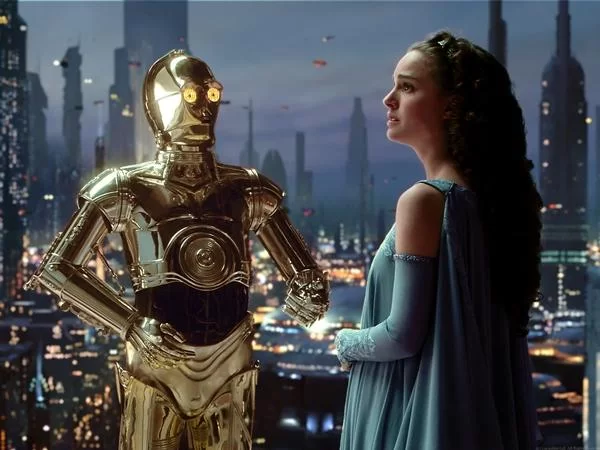


Referências:
https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
https://www.geeksforgeeks.org/convert-text-speech-python/
https://ai.google.dev/api/python/google/generativeai/GenerativeModel
https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=-YilAhGr6gtZ


Próxima etapas e melhorias:


*   Adicionar outras opções de idiomas (bem facíl, apenas adicionar outras opções de prompt)
*   Explorar outros prompts para melhorar as respostas e torná-las mais úteis




